In [1]:
import pandas as pd
import os

<h2>Load and Combine Data</h2>

In [2]:
data = pd.DataFrame()
for i in range(10):
    data = pd.concat([data, pd.read_csv('data\\' + os.listdir('data')[i])])

C:\Users\larve\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (74,75) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
print(data.shape) # 94k data points
print()
print(data.groupby('ITEST_id').first().shape) # 1709 different students included in the dataset

(942816, 77)

(1709, 76)


In [4]:
labels = pd.read_csv('data\\' + 'training_label.csv')
labels.shape # only 514 STEM career labels recorded for 1709 students

(514, 5)

In [5]:
training_data = labels.loc[:, ['ITEST_id', 'isSTEM']].merge(data, on = 'ITEST_id', how = 'inner')
print(training_data.shape) # 270k training data points
print()
print(training_data.groupby('ITEST_id').first().shape) # 467 different students after merging

(272562, 78)

(467, 77)


In [6]:
pd.set_option('display.max_columns', None)
training_data.head(3)

,ITEST_id,isSTEM,SY ASSISTments Usage,AveKnow,AveCarelessness,AveCorrect,NumActions,AveResBored,AveResEngcon,AveResConf,AveResFrust,AveResOfftask,AveResGaming,actionId,skill,problemId,assignmentId,assistmentId,startTime,endTime,timeTaken,correct,original,hint,hintCount,hintTotal,scaffold,bottomHint,attemptCount,problemType,frIsHelpRequest,frPast5HelpRequest,frPast8HelpRequest,stlHintUsed,past8BottomOut,totalFrPercentPastWrong,totalFrPastWrongCount,frPast5WrongCount,frPast8WrongCount,totalFrTimeOnSkill,timeSinceSkill,frWorkingInSchool,totalFrAttempted,totalFrSkillOpportunities,responseIsFillIn,responseIsChosen,endsWithScaffolding,endsWithAutoScaffolding,frTimeTakenOnScaffolding,frTotalSkillOpportunitiesScaffolding,totalFrSkillOpportunitiesByScaffolding,frIsHelpRequestScaffolding,timeGreater5Secprev2wrong,sumRight,helpAccessUnder2Sec,timeGreater10SecAndNextActionRight,consecutiveErrorsInRow,sumTime3SDWhen3RowRight,sumTimePerSkill,totalTimeByPercentCorrectForskill,prev5count,timeOver80,manywrong,confidence(BORED),confidence(CONCENTRATING),confidence(CONFUSED),confidence(FRUSTRATED),confidence(OFF TASK),confidence(GAMING),RES_BORED,RES_CONCENTRATING,RES_CONFUSED,RES_FRUSTRATED,RES_OFFTASK,RES_GAMING,Ln-1,Ln,Prev5count
0,9,1,2005-2006,0.185138,0.099734,0.438492,504,0.277149,0.644744,0.098078,0.162771,0.213378,0.005554,11006,reading-graph,178,723,178,1131985185,1131985200,15.0,0,1,1,1,1,0,0,1,textfieldquestion,1,0,0,0,0,0.0,0,0,0,0.000000,0.0,1,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0.0,15.0,0.0,0.0,0,0,0.597865,0.234294,0.0,0.000000,0.838710,0.008522,0.376427,0.320317,0.0,0.000000,0.785585,0.000264,0.212,0.065764,NaN
1,9,1,2005-2006,0.185138,0.099734,0.438492,504,0.277149,0.644744,0.098078,0.162771,0.213378,0.005554,11007,reading-graph,175,723,178,1131985200,1131985296,96.0,1,0,0,0,0,1,0,1,textfieldquestion,1,1,1,0,0,0.0,0,0,0,15.000001,0.0,1,1,1,0,0,1,0,96.0,0,0.0,1,0,1,0,1,0,0.0,111.0,222.0,1.0,1,0,0.355694,0.164687,0.0,0.091463,0.000000,0.047821,0.156027,0.225154,0.0,0.009561,0.000000,0.001483,0.065764,0.211371,NaN
2,9,1,2005-2006,0.185138,0.099734,0.438492,504,0.277149,0.644744,0.098078,0.162771,0.213378,0.005554,11008,reading-graph,176,723,178,1131985296,1131985347,51.0,1,0,0,0,0,1,0,1,textfieldquestion,1,2,2,0,0,0.0,0,0,0,111.000000,0.0,1,2,2,0,0,1,0,51.0,1,2.0,1,0,2,0,1,0,0.0,162.0,243.0,2.0,0,0,0.355694,0.499267,0.0,0.091463,0.280702,0.047821,0.156027,0.665929,0.0,0.009561,0.149121,0.001483,0.211371,0.482049,NaN


<h2>Investigate Null Values</h2>

In [7]:
training_data.drop(columns = ['Prev5count', 'prev5count'], inplace = True) # drop columns with mostly nan values

In [8]:
training_data.isna().any(axis=1).sum() # 22 data points out of 270k have nan values, so we can likely drop the 22 rows without biasing our data
training_data.dropna(inplace = True)

<h2>Investigate Pardos et al. (2014) Student Affects</h2>

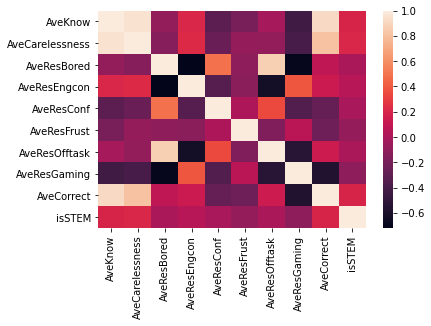

In [9]:
import seaborn as sns
correlations = training_data.groupby('ITEST_id').first()[['AveKnow','AveCarelessness', 'AveResBored','AveResEngcon', 'AveResConf', 'AveResFrust', 'AveResOfftask','AveResGaming', 'AveCorrect', 'isSTEM']].corr()
sns.heatmap(correlations);
# correlation heatmap of student affects, correctness on exams, and STEM careers

In [10]:
correlations['isSTEM'] # Numerical output of the final columns in the heatmap, correlations with STEM career

AveKnow            0.199700
AveCarelessness    0.206977
AveResBored        0.001594
AveResEngcon       0.052367
AveResConf        -0.003772
AveResFrust       -0.080541
AveResOfftask      0.009078
AveResGaming      -0.106649
AveCorrect         0.193825
isSTEM             1.000000
Name: isSTEM, dtype: float64

There are a few interesting things to note from the correlation heat map:
- The traits highly associated with success on the exams (AveCorrect) are student knowledge and carelessness (surprisingly, but this makes sense according to the abstract in the paper where the carelessness trait is studied. Engaged students will make silly mistakes (slips).  https://www.researchgate.net/publication/221622185_The_Relationship_between_Carelessness_and_Affect_in_a_Cognitive_Tutor)
- The traits negatively associated with success are confusion, frustration, and gaming the system
- The traits positively associated with entering a STEM career are knowledge, carelessness on the exams, and correctness, and to a lesser degree, engaged concentration
- The traits negatively associated with entering a STEM career are frustration and gaming the system. Surprisingly, confusion is not significantly correlated with entering a STEM field although it is correlated with success on the exams. A possible explanation for this is that confused students are not necesarilly uninterested in the work they are doing, but just need some more time and help. 



<h2>Visualize the Amount of Positive and Negative isSTEM examples in the Dataset</h2> 

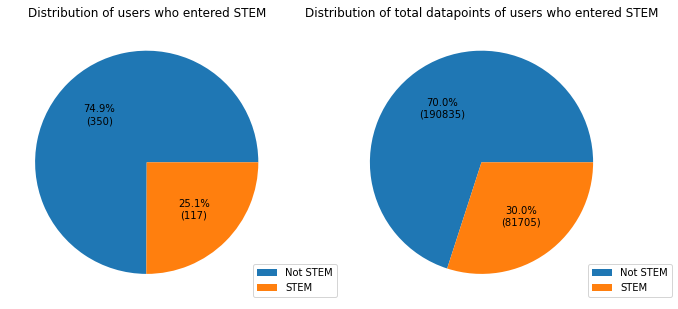

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

labels = ['Not STEM', 'STEM']

user_careers = training_data.groupby('ITEST_id').first()['isSTEM'].value_counts().values
total_datapoints_careers = training_data['isSTEM'].value_counts().values

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(11, 10.5)

ax1.pie(user_careers, autopct=lambda pct: func(pct, user_careers));
ax1.legend(labels = labels, loc = 'lower right', bbox_to_anchor=(.7, 0, 0.5, 1));
ax1.set_title('Distribution of users who entered STEM');

ax2.pie(total_datapoints_careers, autopct = lambda pct: func(pct, total_datapoints_careers));
ax2.legend(labels = labels, loc = 'lower right', bbox_to_anchor=(.7, 0, 0.5, 1));
ax2.set_title('Distribution of total datapoints of users who entered STEM');

One quarter of the users in the data entered STEM careers, while three tenths of the total datapoints come from users who entered STEM